For regular chunked stochastic forward simulation, as with the MPR backend, we would create the buffer, and step through it, rewriting the noise samples with the computed time series, something like this

In [1]:
import jax.numpy as np
import jax
from jax.test_util import check_grads

keys = jax.random.split(jax.random.PRNGKey(0), 10)
nn = 84
weights = np.abs(jax.random.normal (keys[0], (nn, nn)))+0.5
lengths = jax.random.randint(keys[1], (nn, nn), 0, 255)
nh = lengths.max() + 1
nt = 100
buffer = jax.random.normal(keys[2], (nn, nh + nt))
nn = weights.shape[0]
ns = np.tile(np.arange(nn),(nn,1))

In [2]:
@jax.jit
def run(buffer):
    # TODO convert to scan?
    for t in range(nt):
        x_t = np.mean(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t].set(x_t)
    return buffer

b1 = run(buffer)
%timeit run(buffer)

1.15 ms ± 9.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
loss = lambda b: np.sum(np.square(b1 - run(b)))
gloss = jax.jit(jax.grad(loss))
gloss(b1).shape

(84, 355)

In [4]:
%timeit gloss(b1+1)

32.9 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
# n=1 run 16us & gloss 52us
# n=10 run 118us & gloss 590us
# n=100 run 1150 us & gloss 32700us

The tricky bit with a scan is the carry,

In [6]:
jax.lax.scan?

In [7]:
def make_run(nt):
    def op(buffer, t):
        x_t = np.mean(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t].set(x_t)
        return buffer, x_t
    @jax.jit
    def run(buffer):
        b, x = jax.lax.scan(op, buffer, np.r_[:nt])
        return b
    return op, run

op, run2 = make_run(nt)
run2(buffer).shape
%timeit run2(buffer)

1.34 ms ± 9.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
loss2 = lambda b: np.sum(np.square(b1 - run2(b)))
gloss2 = jax.jit(jax.grad(loss2))
gloss2(b1).shape
%timeit gloss2(b1+1)

5.46 ms ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


About 4x slower.. could it be any better with custom vjp? well let''s look at what it's actually doing:

In [9]:
f = lambda b: np.sum(np.square(op(b,0)[0]))

jax.make_jaxpr(jax.grad(f))(b1)

{ lambda a:i32[] b:i32[84,84] c:i32[84,84] d:f32[84,84]; e:f32[84,355]. let
    f:i32[] = add a 0
    g:i32[84,84] = sub f b
    h:bool[84,84] = lt c 0
    i:i32[84,84] = add c 84
    j:i32[84,84] = select_n h c i
    k:bool[84,84] = lt g 0
    l:i32[84,84] = add g 355
    m:i32[84,84] = select_n k g l
    n:i32[84,84,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(84, 84, 1)
    ] j
    o:i32[84,84,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(84, 84, 1)
    ] m
    p:i32[84,84,2] = concatenate[dimension=2] n o
    q:f32[84,84] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0, 1), start_index_map=(0, 1))
      fill_value=None
      indices_are_sorted=False
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1, 1)
      unique_indices=False
    ] e p
    r:f32[84,84] = mul d q
    s:f32[84] = reduce_sum[axes=(1,)] r
    t:f32[84] = div s 84.0
    u:i32[] = add a 0
    v:bool[] = 

This is interesting because it tells us that we have gather, scatter, scatter, gather here, to compute the gradient.  Can't some of that work be kept from the forward pass?  In any case, the jaxpr here is useful to understand what those clever transformations liek `jax.grad` are doing.

## custom vjp of scan `op`

If we have a scan forward, we have to have a scan backward, but we can amortize the cost by saving some of the work?

Read https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html carefully first, and make sure we know how to handle multiple inputs & outputs,

In [10]:
# simple example with two outputs, how to do?
@jax.custom_vjp
def foo(a, b):
    return 2*a+b, 3*a+0.5*b

def foo_fwd(a, b):
    return foo(a, b), None

def foo_bwd(res, g):
    g_1, g_2 = g
    return (2*g[0]+3*g[1], g[0] + 0.5*g[1])

foo.defvjp(foo_fwd, foo_bwd)

def bar(a, b):
    c, d = foo(a, b)
    return 2*c + 3*d

jax.grad(bar, [0,1])(3.,4.)

jax.test_util.check_grads(bar, (3.0, 4.0), order=1, modes=('rev',))

With that simple example in mind we can handle `op(buffer,t) -> (c, x)`:

In [16]:
import numpy as onp

@jax.custom_vjp
def op(buffer, t):
    x_t = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
    if isinstance(buffer, onp.ndarray):
        buffer = np.array(buffer)
    buffer = buffer.at[:, nh + t].set(x_t)
    return buffer, x_t

def op_fwd(buffer, t):
    return op(buffer, t), (t,)

def op_bwd(res, g):
    t, = res
    g_buffer, g_x = g  # shaped (nn, nh+nt) & (nn, )
    g_x_b = np.tile(g_x[:,None],(1,nn)) # rev of sum(b,axis=1)
    g_buf = np.zeros_like(buffer).at[ns, nh + t - lengths].add(weights * g_x_b)
    return g_buf, None

op.defvjp(op_fwd, op_bwd)

# try x first
def bar(b):
    b, x = op(b, 0)
    return np.sum(x)

jax.grad(bar)(b1)

jax.test_util.check_grads(bar, (b1, ), order=1, modes=('rev',))

So that works, what does the output look like?

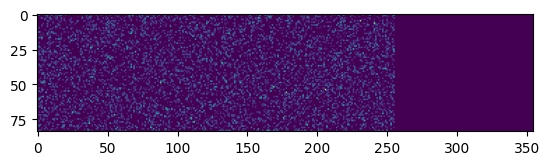

In [20]:
%matplotlib inline
import matplotlib.pyplot as pl

pl.imshow(jax.grad(bar)(b1))